In [4]:
import xarray as xr
import torch
import numpy as np
import os
import json
import copy
import numpy as np
import shutil
from scipy.io import netcdf


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid


'''
os.system("jupyter nbconvert --to script 'climate_train.ipynb'")
os.system("jupyter nbconvert --to script 'climate_data.ipynb'")
os.system("jupyter nbconvert --to script 'climate_models.ipynb'")
os.system("jupyter nbconvert --to script 'climate_job_maintenance.ipynb'")
'''
import climate_train as ct
import climate_data
import climate_models
import climate_job_maintenance as cjm

def longitude_average(R2):
    mr2=np.zeros((R2.shape[0],R2.shape[1]))
    sr2=np.zeros((R2.shape[0],R2.shape[1]))
    for t in range(R2.shape[0]*R2.shape[1]):
        i=t%R2.shape[0]
        j=t//R2.shape[0]
        rr=R2[i,j]
        rr=rr[rr>0]
        rr[rr>1]=1
        with np.errstate(divide='ignore'):
            if len(rr)>0:
                mr2[i,j]=np.mean(rr)
                sr2[i,j]=np.std(rr)
    return mr2,sr2
def longitude_full_average(R2):
    mr2=np.zeros(R2.shape[0])
    sr2=np.zeros(R2.shape[0])
    for t in range(R2.shape[0]):
        rr=R2[t]
        rr=rr[rr>0]
        rr[rr>1]=1
        with np.errstate(divide='ignore'):
            if len(rr)>0:
                mr2[t]=np.mean(rr)
                sr2[t]=np.std(rr)
    return mr2,sr2
def code2vals(num,C):
    T=[]
    for i in range(len(C)):
        T.append(num%C[i])
        num=num//C[i]
    return T

In [5]:
# DATASET (2)
# SURF/DEEP 

# ARCHITECTURE (3)
# LCNN/QCNN/UNET

# SIGMAVALS (4)
# 4 8 12 16 

# GEOPHYS (3)
# NONE - GLOBAL - (GLOBAL+COORDS)

# RESIDUE TARGET(2)
# YES - NO

In [6]:
args=ct.options(string_input="-b 3".split())

In [7]:
offset=3000
args.model_id=offset
args.model_bank_id="G"
root='/scratch/cg3306/climate/runs/'
C,names=climate_models.golden_model_bank(args,only_description=True,verbose=True)

root improvement 3000
	temp
		no - yes - 
	global
		no - yes - 
	res
		no - yes - 
	geophys
		no - yes - 
	sigma
		4 - 8 - 12 - 16 - 


In [8]:
s=0
x=[[0,1],[0,1],[0],[0],[s]]
J=cjm.jobnums(C=C,x=x,offset=offset)
print(J)

[3000, 3001, 3002, 3003]


In [9]:

x=[[0,1],[0,1],[0],[0],[s]]
J=cjm.jobnums(C=C,x=x,offset=offset)

#testing res
x=[[1],[1],[0,1],[1],[s]]
J+=cjm.jobnums(C=C,x=x,offset=offset)

In [14]:
s=1

x=[[0,1],[1],[0],[0],[s]]
J=cjm.jobnums(C=C,x=x,offset=offset)

#testing res
x=[[1],[1],[0,1],[1],[s]]
J+=cjm.jobnums(C=C,x=x,offset=offset)

In [15]:
J

[3018, 3019, 3027, 3031]

In [7]:
def cartopy_subplot(fig,nrow,ncol,index,lons,lats,u,title,exts=[]):
    ax = plt.subplot(nrow,ncol,index, projection=ccrs.Robinson())
    if len(exts)==0:
        umax=u[u==u].max()
        umin=u[u==u].min()
    else:
        umin,umax=exts[0],exts[1]
    ds=xr.Dataset(data_vars=dict(u=(["latitude","longitude"],u)),\
                            coords=dict(latitude=lats,longitude=lons))

    cax=ds.u.plot(ax=ax, transform = ccrs.PlateCarree(),\
                  cmap='coolwarm',\
                  norm=mcolors.LogNorm(vmin=umin,vmax=umax),\
                  add_colorbar=False)
    ax.set_title(title)
    ax.coastlines()
    
    tickvals=[10**(-(i-1)) for i in range(8)]
    tickstr=[str(tt) for tt in tickvals]
    cbar = fig.colorbar(cax, ticks=tickvals,fraction=0.035, pad=0.04)
    cbar.ax.set_yticklabels(tickstr)
    

In [8]:
lookupfile='/scratch/cg3306/climate/climate_research/model_data_info.json'
with open(lookupfile) as infile:
    datainfo=json.load(infile)

In [9]:
sigmas=[4,8,12,16]
offset=3000
sigma=sigmas[s]

(0.0, 1.0)

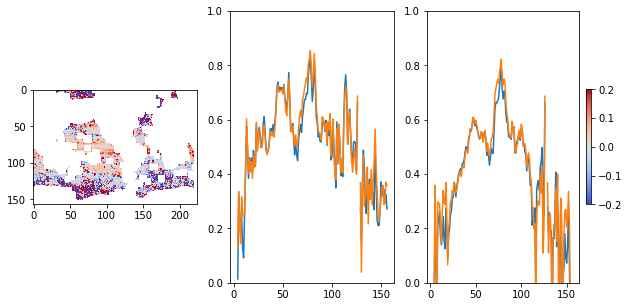

In [26]:
KS=[4,5]
VARS=[]
j=0
for l in range(2):
    k=KS[l]
    foldername='G-'+str(J[k])
    with np.errstate(divide='ignore'):
        MSE=np.load(root+foldername+'/MSE.npy')
        SC2=np.load(root+foldername+'/SC2.npy')
    if len(MSE.shape)>3:
        MSE=MSE[0]
        SC2=SC2[0]
    MSE=MSE[j]
    SC2=SC2[j]
    
    
    root='/scratch/cg3306/climate/runs/'
    raw_data_address='/scratch/zanna/data/cm2.6/coarse-3D-data-sigma-'+str(sigma)+'.zarr'
    ds_zarr=xr.open_zarr(raw_data_address)
    
    lon=ds_zarr.xu_ocean.values
    lat=ds_zarr.yu_ocean.values
        
    
    spread=(len(lat)-MSE.shape[0])//2
    if spread>0:
        lat=lat[spread:-spread]
    MASK=np.load(datainfo['G'][str(J[k])]['maskloc'].replace('dom4','glbl'))[0,0]
    
    MSE[MASK==0]=np.nan
    SC2[MASK==0]=np.nan
    MSE[SC2==0]=np.nan
    SC2[SC2==0]=np.nan
    R2=1-MSE/SC2
    MSE[MSE!=MSE]=0
    SC2[SC2!=SC2]=0
    Z=np.sum(SC2,axis=1)
    Z[Z==0]=np.nan
    LATR2=1-np.sum(MSE,axis=1)/Z
    R2_=R2*0+1
    R2_[R2_!=R2_]=0
    N_=np.sum(R2_,axis=1)
    N_[N_==0]=np.nan
    R2_=R2*1
    R2_[R2_!=R2_]=0
    LONGAVGR2=np.sum(R2_,axis=1)/N_
    VARS.append([MSE,SC2,R2,LATR2,LONGAVGR2])

R2rat=(VARS[1][2]-VARS[0][2])/VARS[0][2]
fig,axs=plt.subplots(1,3,figsize=(10,5))
ax=axs[0]
cax=ax.imshow(R2rat[::-1],vmin=-0.2,vmax=0.2,cmap='coolwarm')
cbar = fig.colorbar(cax, fraction=0.035, pad=0.04)

ax=axs[1]
ax.plot(VARS[0][3])
ax.plot(VARS[1][3])
ax.set_ylim([0,1])

ax=axs[2]
ax.plot(VARS[0][4])
ax.plot(VARS[1][4])
ax.set_ylim([0,1])

In [11]:
sigma=4
raw_data_address='/scratch/zanna/data/cm2.6/coarse-3D-data-sigma-'+str(sigma)+'.zarr'
ds_zarr=xr.open_zarr(raw_data_address)

In [12]:
usurf=ds_zarr.isel(time=0).isel(st_ocean=0).usurf.values
lon=ds_zarr.xu_ocean.values
lat=ds_zarr.yu_ocean.values

In [13]:
usurf.shape, MSE.shape,len(lat[10:-10])

((645, 900), (625, 900), 625)

In [14]:
MSE[MSE==0]=np.nan

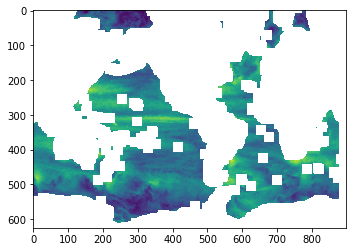

In [15]:
plt.imshow(np.log(MSE[::-1]))

In [16]:
k=1
j=0
foldername='G-'+str(J[k])
with np.errstate(divide='ignore'):
    MSE=np.load(root+foldername+'/MSE.npy')
    SC2=np.load(root+foldername+'/SC2.npy')
if len(MSE.shape)>3:
    MSE=MSE[0]
    SC2=SC2[0]
MSE=MSE[j]
SC2=SC2[j]

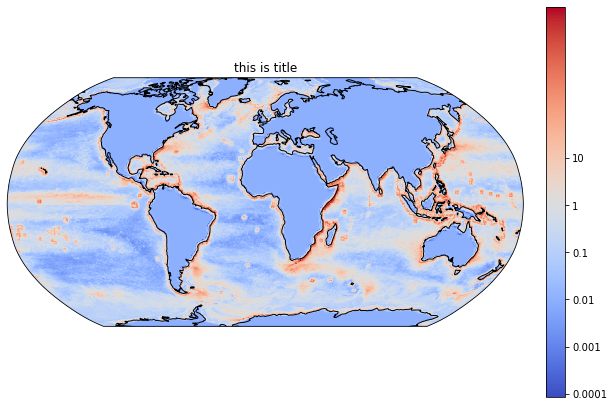

In [17]:
fig,axs=plt.subplots(1,1,figsize=(10,10))

cartopy_subplot(fig,1,1,1,lon,lat[10:-10],MSE,'this is title',exts=[])

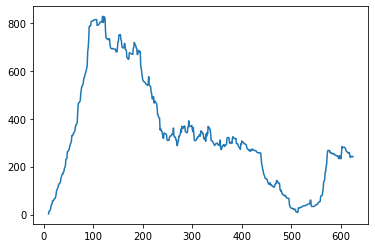

In [18]:
plt.plot(N_)

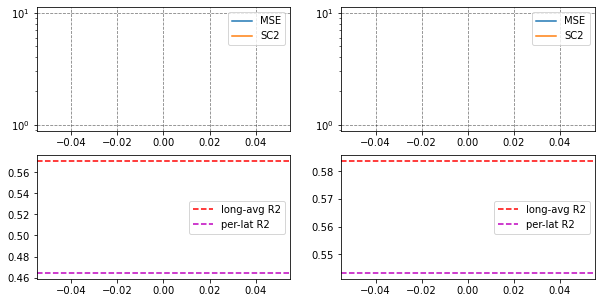

In [25]:
i=100
j=0
material=[]
KS=[4,5]

for l in range(2):
    k=KS[l]
    foldername='G-'+str(J[k])
    with np.errstate(divide='ignore'):
        MSE=np.load(root+foldername+'/MSE.npy')
        SC2=np.load(root+foldername+'/SC2.npy')
    if len(MSE.shape)>3:
        MSE=MSE[0]
        SC2=SC2[0]
    MSE=MSE[j]
    SC2=SC2[j]
    MASK=np.load(datainfo['G'][str(J[k])]['maskloc'].replace('dom4','glbl'))[0,0]

    MSE[MASK==0]=np.nan
    SC2[MASK==0]=np.nan
    MSE[SC2==0]=np.nan
    SC2[SC2==0]=np.nan
    R2=1-MSE/SC2
    
    
    mse=MSE[i]
    sc2=SC2[i]
    r2=R2[i]
    
    
    meanr2=np.mean(r2[r2==r2])
    fullr2=1-np.mean(mse[mse==mse])/np.mean(sc2[sc2==sc2])
    material.append([xx[I],mse[I],sc2[I],r2[I],meanr2,fullr2])
fig,axs=plt.subplots(2,2,figsize=(10,5))
for l in range(2):
    xx,mse,sc2,r2,meanr2,fullr2=material[l]
    
    axs[0,l].semilogy(xx,mse,label='MSE')
    axs[0,l].semilogy(xx,sc2,label='SC2')
    axs[0,l].legend()
    axs[0,l].grid(color='k',linestyle='--',alpha=0.5)
    #axs[0,l].set_ylim([1e-6,1e1])
    axs[1,l].plot(xx,r2)
    axs[1,l].axhline(y=meanr2,linestyle='--',color='r',label='long-avg R2')
    axs[1,l].axhline(y=fullr2,linestyle='--',color='m',label='per-lat R2')
    axs[1,l].legend()
    #axs[1,l].set_ylim([-1,1])

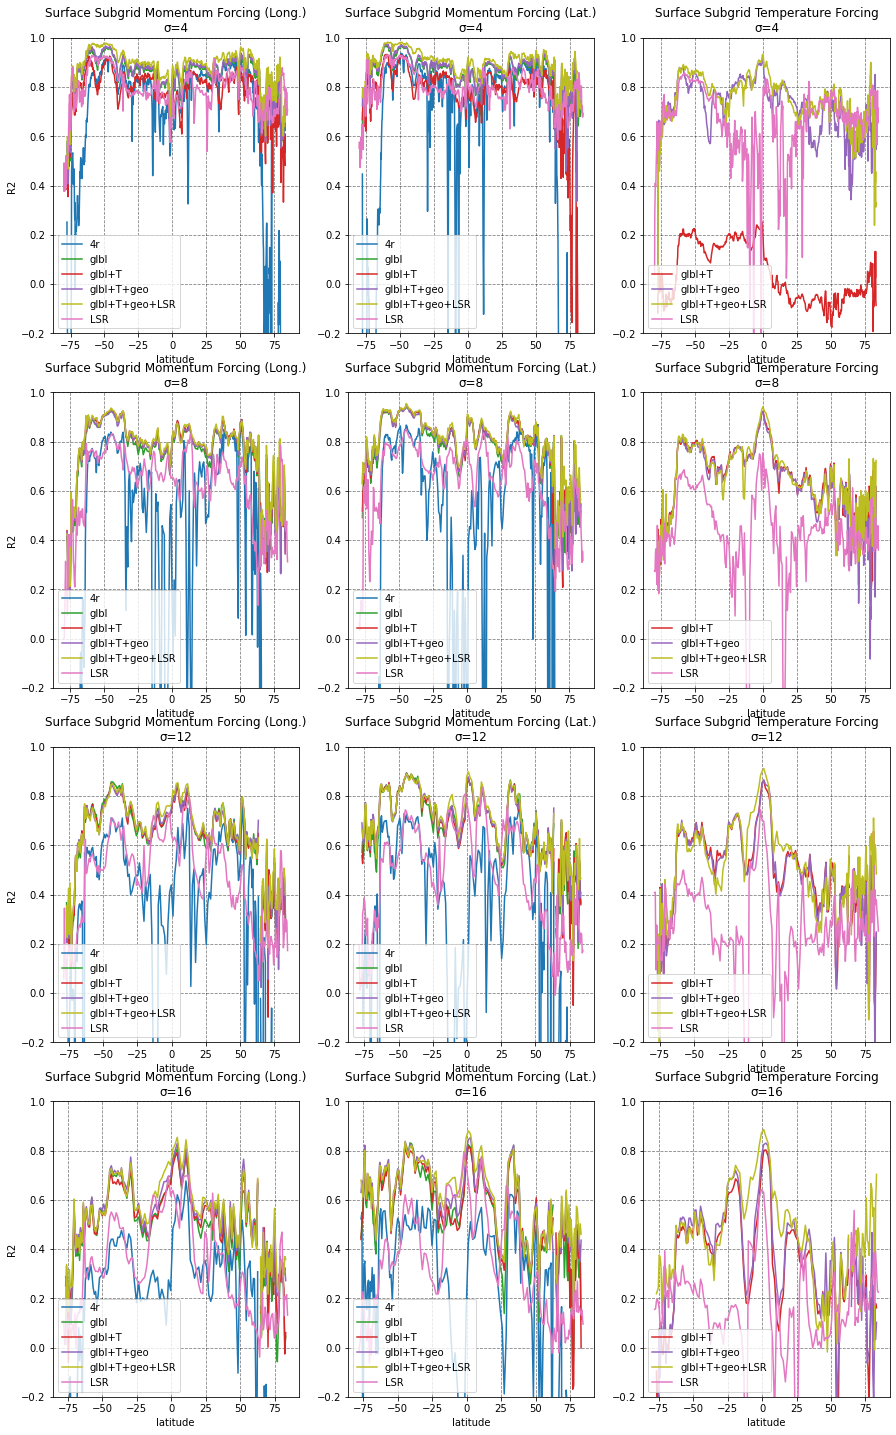

In [37]:
colors=['blue','orange','green','red','purple','olive','pink']
colors=['tab:'+cc for cc in colors]

lookupfile='/scratch/cg3306/climate/climate_research/model_data_info.json'
with open(lookupfile) as infile:
    datainfo=json.load(infile)
    
sigmas=[4,8,12,16]
offset=3000

fig,axs=plt.subplots(len(sigmas),3,figsize=(15,25))
fig.patch.set_facecolor('white')
datype=['Surface Subgrid Momentum Forcing (Long.)','Surface Subgrid Momentum Forcing (Lat.)','Surface Subgrid Temperature Forcing']


mseflag=0

for s in range(len(sigmas)):
    sigma=sigmas[s]
    raw_data_address='/scratch/zanna/data/cm2.6/coarse-3D-data-sigma-'+str(sigma)+'.zarr'
    ds_zarr=xr.open_zarr(raw_data_address)
    xx=ds_zarr.yu_ocean.values

    
    #testing global or 4reg training
    x=[[0,1],[0,1],[0],[0],[s]]
    J=cjm.jobnums(C=C,x=x,offset=offset)

    #testing res
    x=[[1],[1],[0,1],[1],[s]]
    J+=cjm.jobnums(C=C,x=x,offset=offset)


    lines=['4r','4r+T','glbl','glbl+T','glbl+T+geo','glbl+T+geo+LSR','LSR']
    ranks=np.arange(len(lines)).tolist()

    for j in [0,1,2]:
        ax=axs[s,j]
        root='/scratch/cg3306/climate/runs/'
        for k in [0]+np.arange(2,len(J)+1).tolist():
            readfile=True
            if k==len(J):
                MSELOC='/scratch/cg3306/climate/projection_analysis/surf-data-sigma-'+str(sigma)+'MSE.npy'
                SC2LOC=MSELOC.replace('MSE','SC2')
                with np.errstate(divide='ignore'):
                    MSE=np.load(MSELOC)
                    SC2=np.load(SC2LOC)
                MSE[MSE!=MSE]=0
                SC2[SC2!=SC2]=0
            else:
                foldername='G-'+str(J[k])
                try:
                    with np.errstate(divide='ignore'):
                        MSE=np.load(root+foldername+'/MSE.npy')
                        SC2=np.load(root+foldername+'/SC2.npy')
                    if len(MSE.shape)>3:
                        MSE=MSE[0]
                        SC2=SC2[0]
                    #print(MSE.shape,lines[ranks[k]])
                    MASK=np.load(datainfo['G'][str(J[k])]['maskloc'].replace('dom4','glbl'))[0,0]
                    MSE[:,MASK==0]=np.nan
                    SC2[:,MASK==0]=np.nan
                    MSE[SC2==0]=np.nan
                    SC2[SC2==0]=np.nan
                    R2=1-MSE/SC2
                    MSE[MSE!=MSE]=0
                    SC2[SC2!=SC2]=0
                    
                    Z=np.sum(SC2,axis=1)
                    Z[Z==0]=np.nan
                    LATR2=1-np.sum(MSE,axis=1)/Z
                    R2_=R2*0+1
                    R2_[R2_!=R2_]=0
                    N_=np.sum(R2_,axis=1)
                    N_[N_==0]=np.nan
                    R2_=R2*1
                    R2_[R2_!=R2_]=0
                    LONGAVGR2=np.sum(R2_,axis=1)/N_
                    
                    
                except:
                    readfile=False
                    #print(foldername)
            if readfile:
                if k!=len(J):
                    outscales=np.array(datainfo['G'][str(J[k])]['outscales'])**2
                    MSE=MSE*outscales.reshape([-1,1,1])
                    SC2=SC2*outscales.reshape([-1,1,1])
                if MSE.shape[0]>j:
                    Z=SC2[j]*1
                    Z[Z==0]=np.nan
                    if mseflag:
                        if mseflag==1:
                            R2=MSE[j]*1
                        else:
                            R2=SC2[j]*1
                        mr2=np.zeros(R2.shape[0])
                        spread=(len(xx)-MSE.shape[1])//2
                        for i in range(R2.shape[0]):
                            rr=R2[i]
                            rr=rr[rr>0]
                            if len(rr)>0:
                                with np.errstate(divide='ignore'):
                                    mr2[i]=np.mean(rr)
                            else:
                                mr2[i]=np.nan
                    else:
                        MSE[MSE!=MSE]=0
                        SC2[SC2!=SC2]=0
                        Z=np.sum(SC2,axis=2)#+1e-5
                        Z[Z==0]=np.nan
                        mr2=1-np.sum(MSE,axis=2)/Z
                        mr2=mr2[j]
                        spread=(len(xx)-MSE.shape[1])//2
                    if spread>0:
                        x=xx[spread:-spread]
                    else:
                        x=xx*1
                    if mseflag:
                        ax.semilogy(x,mr2,label=lines[ranks[k]],color=colors[ranks[k]])
                    else:
                        ax.plot(x,mr2,label=lines[ranks[k]],color=colors[ranks[k]])
                        ax.set_ylim([-.2,1])
        if j==0:
            if mseflag==1:
                ax.set_ylabel('MSE (1e-14 $m^2/s^4$)')
            elif mseflag==2:
                ax.set_ylabel('SC2 (1e-14 $m^2/s^4$)')
            else:
                ax.set_ylabel('R2')
        ax.set_xlabel('latitude')
        title='\u03C3='+str(sigma)
        title=datype[j]+'\n'+title
        ax.set_title(title)
        ax.legend(loc='lower left')
        ax.grid(color='k',linestyle='--',alpha=0.5)

In [34]:


lookupfile='/scratch/cg3306/climate/climate_research/model_data_info.json'
with open(lookupfile) as infile:
    datainfo=json.load(infile)
    
sigmas=[4,8,12,16]
offset=3000


mseflag=0

r2vals=np.zeros((len(sigmas),3,len(J)+1,2))*np.nan
for s in range(len(sigmas)):
    sigma=sigmas[s]
    raw_data_address='/scratch/zanna/data/cm2.6/coarse-3D-data-sigma-'+str(sigma)+'.zarr'
    ds_zarr=xr.open_zarr(raw_data_address)
    xx=ds_zarr.yu_ocean.values

    #testing global or 4reg training
    x=[[0,1],[0,1],[0],[0],[s]]
    J=cjm.jobnums(C=C,x=x,offset=offset)

    #testing res
    x=[[1],[1],[0,1],[1],[s]]
    J+=cjm.jobnums(C=C,x=x,offset=offset)



    lines=['4r','4r+T','glbl','glbl+T','glbl+T+geo','glbl+T+geo+LSR','LSR']
    ranks=np.arange(len(lines)).tolist()


    for j in [0,1,2]:
        root='/scratch/cg3306/climate/runs/'
        for k in range(len(J)+1):
            readfile=True
            
            if k==len(J):
                MSELOC='/scratch/cg3306/climate/projection_analysis/surf-data-sigma-'+str(sigma)+'MSE.npy'
                SC2LOC=MSELOC.replace('MSE','SC2')
                with np.errstate(divide='ignore'):
                    MSE=np.load(MSELOC)
                    SC2=np.load(SC2LOC)
                MSE[MSE!=MSE]=0
                SC2[SC2!=SC2]=0
            else:
                foldername='G-'+str(J[k])
                try:
                    with np.errstate(divide='ignore'):
                        MSE=np.load(root+foldername+'/MSE.npy')
                        SC2=np.load(root+foldername+'/SC2.npy')
                    if len(MSE.shape)>3:
                        MSE=MSE[0]
                        SC2=SC2[0]
                    #print(MSE.shape,lines[ranks[k]])
                    MASK=np.load(datainfo['G'][str(J[k])]['maskloc'].replace('dom4','glbl'))[0,0]
                    MSE[:,MASK==0]=np.nan
                    SC2[:,MASK==0]=np.nan
                    MSE[SC2==0]=np.nan
                    SC2[SC2==0]=np.nan
                except:
                    readfile=False
                    #print(foldername)
                    
            if readfile:
                if MSE.shape[0]>j:
                    MSE[MSE!=MSE]=0
                    SC2[SC2!=SC2]=0
                    r2vals[s,j,k,0]=1-np.sum(MSE[j])/np.sum(SC2[j])
                    
                    MSE=MSE[j]
                    SC2=SC2[j]
                    
                    SC2[SC2==0]=np.nan
                    R2=1-MSE/SC2
                    r2vals[s,j,k,1]=np.mean(R2[R2>=0])

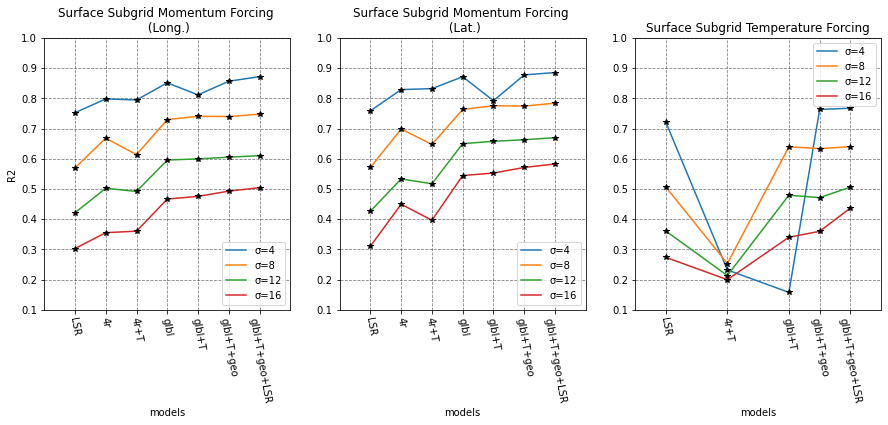

In [35]:


lookupfile='/scratch/cg3306/climate/climate_research/model_data_info.json'
with open(lookupfile) as infile:
    datainfo=json.load(infile)
    
sigmas=[4,8,12,16]
offset=3000

fig,axs=plt.subplots(1,3,figsize=(15,5))
fig.patch.set_facecolor('white')
datype=['Surface Subgrid Momentum Forcing \n (Long.)','Surface Subgrid Momentum Forcing \n (Lat.)','Surface Subgrid Temperature Forcing']


mseflag=0
KK=1

for s in range(len(sigmas)):
    sigma=sigmas[s]

     #testing global or 4reg training
    x=[[0,1],[0,1],[0],[0],[s]]
    J=cjm.jobnums(C=C,x=x,offset=offset)

    #testing res
    x=[[1],[1],[0,1],[1],[s]]
    J+=cjm.jobnums(C=C,x=x,offset=offset)



    lines=['4r','4r+T','glbl','glbl+T','glbl+T+geo','glbl+T+geo+LSR','LSR']
    ranks=np.arange(len(lines)).tolist()

    reordering=np.array([6,0,1,2,3,4,5])
    m=len(reordering)
    for j in [0,1,2]:
        lines=['4r','4r+T','glbl','glbl+T','glbl+T+geo','glbl+T+geo+LSR','LSR']
        lines=[lines[i] for i in reordering]
        ax=axs[j]
        xaxis=np.arange(m)
        yvals=r2vals[s,j,reordering,KK]
        I=np.where(1-np.isnan(yvals))[0]
        xaxis=xaxis[I]
        yvals=yvals[I]
        lines=[lines[i] for i in I]
        ax.plot(xaxis,yvals,label='\u03C3='+str(sigma))
        ax.plot(xaxis,yvals,'*k')
        if s==1:
            if j==0:
                ax.set_ylabel('R2')
            ax.set_xlabel('models')
            title=datype[j]
            ax.set_title(title)
            ax.grid(color='k',linestyle='--',alpha=0.5)
            ax.set_xticks(xaxis)
            ax.set_xticklabels(lines,rotation=-80)
        ax.set_xlim([-1,m])
        ax.legend()
        ax.set_ylim([0.1,1])

In [76]:
len(lines),I

(5, array([0, 2, 3, 4, 5]))

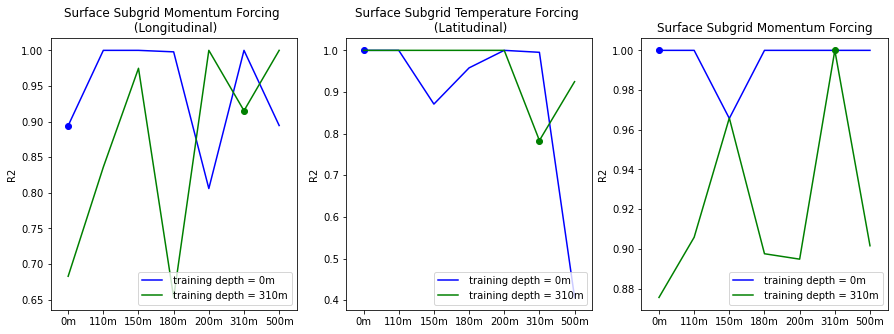

In [71]:
colors=['blue','orange','green','red','purple','olive','pink']
colors=['tab:'+cc for cc in colors]

lookupfile='/scratch/cg3306/climate/climate_research/model_data_info.json'
with open(lookupfile) as infile:
    datainfo=json.load(infile)
    
sigmas=[4,8,12,16]
offset=3000

fig,axs=plt.subplots(len(sigmas),3,figsize=(15,25))
fig.patch.set_facecolor('white')
datype=['Surface Subgrid Momentum Forcing (Long.)','Surface Subgrid Momentum Forcing (Lat.)','Surface Subgrid Temperature Forcing']


mseflag=2

for s in range(len(sigmas)):
    sigma=sigmas[s]
    raw_data_address='/scratch/zanna/data/cm2.6/coarse-3D-data-sigma-'+str(sigma)+'.zarr'
    ds_zarr=xr.open_zarr(raw_data_address)
    xx=ds_zarr.yu_ocean.values

    
    #testing global or 4reg training
    x=[[0,1],[0,1],[0],[0],[s]]
    J=cjm.jobnums(C=C,x=x,offset=offset)

    #testing res
    x=[[1],[1],[0,1],[1],[s]]
    J+=cjm.jobnums(C=C,x=x,offset=offset)


    lines=['4r','4r+T','glbl','glbl+T','glbl+T+geo','glbl+T+geo+LSR','forcing magnitude']
    ranks=np.arange(len(lines)).tolist()

    for j in [0,1,2]:
        ax=axs[s,j]
        root='/scratch/cg3306/climate/runs/'
        for k in np.arange(len(J),len(J)+1).tolist():
            readfile=True
            if k==len(J):
                MSELOC='/scratch/cg3306/climate/projection_analysis/surf-data-sigma-'+str(sigma)+'MSE.npy'
                SC2LOC=MSELOC.replace('MSE','SC2')
                with np.errstate(divide='ignore'):
                    MSE=np.load(MSELOC)
                    SC2=np.load(SC2LOC)
                MSE[MSE!=MSE]=0
                SC2[SC2!=SC2]=0
            else:
                foldername='G-'+str(J[k])
                try:
                    with np.errstate(divide='ignore'):
                        MSE=np.load(root+foldername+'/MSE.npy')
                        SC2=np.load(root+foldername+'/SC2.npy')
                    if len(MSE.shape)>3:
                        MSE=MSE[0]
                        SC2=SC2[0]
                    #print(MSE.shape,lines[ranks[k]])
                    MASK=np.load(datainfo['G'][str(J[k])]['maskloc'].replace('dom4','glbl'))[0,0]
                    MSE[:,MASK==0]=np.nan
                    SC2[:,MASK==0]=np.nan
                    MSE[SC2==0]=np.nan
                    SC2[SC2==0]=np.nan
                    R2=1-MSE/SC2
                    MSE[MSE!=MSE]=0
                    SC2[SC2!=SC2]=0
                    
                    Z=np.sum(SC2,axis=1)
                    Z[Z==0]=np.nan
                    LATR2=1-np.sum(MSE,axis=1)/Z
                    R2_=R2*0+1
                    R2_[R2_!=R2_]=0
                    N_=np.sum(R2_,axis=1)
                    N_[N_==0]=np.nan
                    R2_=R2*1
                    R2_[R2_!=R2_]=0
                    LONGAVGR2=np.sum(R2_,axis=1)/N_
                    
                    
                except:
                    readfile=False
                    #print(foldername)
            if readfile:
                if k!=len(J):
                    outscales=np.array(datainfo['G'][str(J[k])]['outscales'])**2
                    MSE=MSE*outscales.reshape([-1,1,1])
                    SC2=SC2*outscales.reshape([-1,1,1])
                if MSE.shape[0]>j:
                    Z=SC2[j]*1
                    Z[Z==0]=np.nan
                    if mseflag:
                        if mseflag==1:
                            R2=MSE[j]*1
                        else:
                            R2=SC2[j]*1
                        mr2=np.zeros(R2.shape[0])
                        spread=(len(xx)-MSE.shape[1])//2
                        for i in range(R2.shape[0]):
                            rr=R2[i]
                            rr=rr[rr>0]
                            if len(rr)>0:
                                with np.errstate(divide='ignore'):
                                    mr2[i]=np.mean(rr)
                            else:
                                mr2[i]=np.nan
                    else:
                        MSE[MSE!=MSE]=0
                        SC2[SC2!=SC2]=0
                        Z=np.sum(SC2,axis=2)
                        Z[Z==0]=np.nan
                        mr2=1-np.sum(MSE,axis=2)/Z
                        mr2=mr2[j]
                        spread=(len(xx)-MSE.shape[1])//2
                    if spread>0:
                        x=xx[spread:-spread]
                    else:
                        x=xx*1
                    if mseflag:
                        if mseflag==2:
                            ax.semilogy(x,np.sqrt(mr2),label='forcing magnitude',color=colors[ranks[k]])
                        else:
                            ax.semilogy(x,mr2,label=lines[ranks[k]],color=colors[ranks[k]])
                        
                    else:
                        ax.plot(x,mr2,label=lines[ranks[k]],color=colors[ranks[k]])
                        ax.set_ylim([0,1])
        if j==0:
            if mseflag==1:
                ax.set_ylabel('MSE (1e-14 $m^2/s^4$)')
            elif mseflag==2:
                ax.set_ylabel('SC2 (1e-7 $m/s^2$)')
            else:
                ax.set_ylabel('R2')
        ax.set_xlabel('latitude')
        title='\u03C3='+str(sigma)
        title=datype[j]+'\n'+title
        ax.set_title(title)
        ax.legend()
        ax.grid(color='k',linestyle='--',alpha=0.5)

In [ ]:
'''args=options(string_input=\
